In [342]:
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

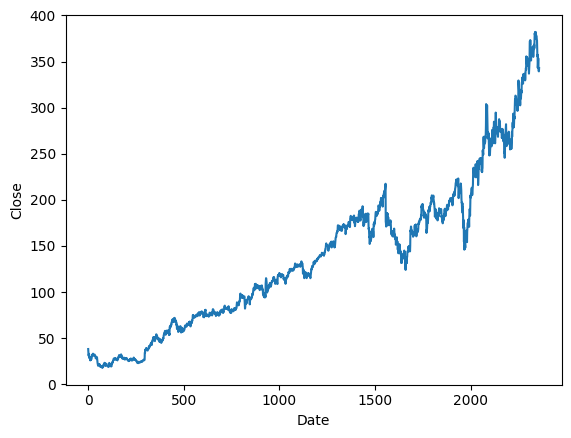

In [343]:
#LoadDataset

dataset = pd.read_csv("sample_data/FB_stock_history.csv")
dataset = dataset[["Date", "Close"]]

plt.xlabel("Date")
plt.ylabel("Close")
plt.plot(dataset["Close"])
plt.show()

In [344]:
#Preprocess the dataset for training purpose
from copy import deepcopy as dc

def preprocess_data(dataset, lookback):
  dataset = dc(dataset)

  for i in range(1, lookback + 1):
    dataset[f"Close - {i}"] = dataset["Close"].shift(i)

  dataset.dropna(inplace = True)
  return dataset


dataset = preprocess_data(dataset, 7)
dataset = dataset.sample(frac = 1)
print(dataset)




            Date       Close   Close - 1  ...   Close - 5   Close - 6   Close - 7
1723  2019-03-27  165.869995  167.679993  ...  165.440002  161.570007  160.470001
1329  2017-08-30  169.919998  168.050003  ...  168.710007  169.639999  167.779999
303   2013-08-05   39.189999   38.049999  ...   35.430000   34.009998   34.360001
61    2012-08-15   21.200001   20.379999  ...   20.719999   20.719999   21.920000
135   2012-12-03   27.040001   28.000000  ...   25.940001   24.000000   24.320000
...          ...         ...         ...  ...         ...         ...         ...
1811  2019-08-01  192.729996  194.229996  ...  200.710007  204.660004  202.360001
1623  2018-10-30  146.220001  142.089996  ...  154.389999  154.779999  154.050003
1348  2017-09-27  167.679993  164.210007  ...  172.169998  172.520004  170.009995
859   2015-10-19   98.470001   97.540001  ...   94.260002   93.239998   92.470001
1875  2019-10-31  191.649994  188.250000  ...  186.380005  186.149994  182.339996

[2352 rows x 9 

In [345]:
#Split dataset into train and test
ratio = 0.93
train_index = len(dataset) * ratio
train_index = int(train_index)

X_train = dataset.iloc[0: train_index, 2:]
Y_train = dataset.iloc[0: train_index, 1]

X_test = dataset.iloc[train_index:, 2:]
Y_test = dataset.iloc[train_index:, 1]


In [346]:
sc = MinMaxScaler()
X_train = X_train.to_numpy().astype(np.float32)
X_train = sc.fit_transform(X_train)
X_test = X_test.to_numpy().astype(np.float32)
X_test = sc.fit_transform(X_test)
Y_train = Y_train.to_numpy().astype(np.float32)
Y_test = Y_test.to_numpy().astype(np.float32)
Y_train = sc.fit_transform(Y_train.reshape(-1, 1))
Y_test = sc.fit_transform(Y_test.reshape(-1, 1))
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

X_train = X_train.view(-1, 7, 1)
Y_train = Y_train.view(-1, 1)
X_test = X_test.view(-1, 7, 1)
Y_test = Y_test.view(-1, 1)
class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

train_dataset = CustomDataset(X_train, Y_train)
test_dataset = CustomDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True)


In [347]:
class TimeSeriesModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first= True)

    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

module = TimeSeriesModel(1, 4, 1)




In [348]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(module.parameters(), lr = 0.001)
num_epoch = len(train_dataloader)

for epoch in range (100):
  for input, output in train_dataloader:
    y_pred = module(input)

    l = loss(y_pred, output)
    l.backward()

    optimizer.step()
    optimizer.zero_grad()

    # if epoch % 10 == 0:
    #   print(f"Epoch: {epoch}, Loss: {l}")

In [360]:
with torch.no_grad():
  running_loss = 0.0
  loss_fn = nn.MSELoss()

  for input, output in test_dataloader:
    y_pred = module(input)
    l = loss_fn(y_pred, output)
    running_loss += l.item()

  avg_loss_across_batches = running_loss / len(test_dataloader)
  print('Average Val Loss: {0:.3f}'.format(avg_loss_across_batches))



Val Loss: 0.000
***************************************************

Val Loss: 0.001
***************************************************

Val Loss: 0.001
***************************************************

Val Loss: 0.001
***************************************************

Val Loss: 0.001
***************************************************

Val Loss: 0.001
***************************************************

Val Loss: 0.001
***************************************************

Val Loss: 0.002
***************************************************

Val Loss: 0.002
***************************************************

Val Loss: 0.002
***************************************************

Val Loss: 0.002
***************************************************

Average Val Loss: 0.000


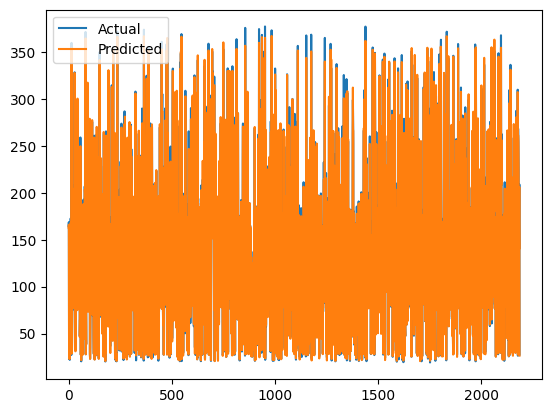

In [349]:
#After trained

with torch.no_grad():
  y_pred = module(X_train)
  y_pred = y_pred.numpy()
  y_pred = sc.inverse_transform(y_pred.reshape(-1, 1))
  Y_train = Y_train.numpy()
  Y_train = sc.inverse_transform(Y_train.reshape(-1, 1))
  plt.plot(Y_train, label = "Actual")
  plt.plot(y_pred, label = "Predicted")
  plt.legend()
  plt.show()

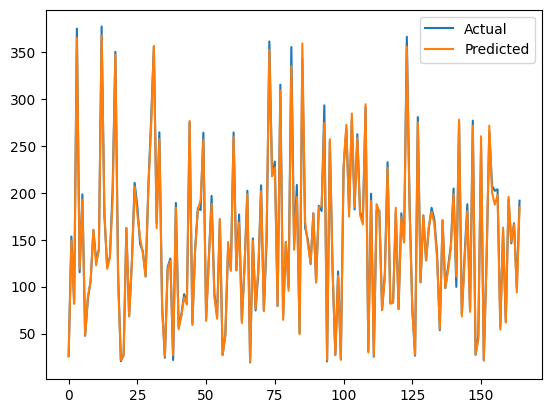

In [351]:
#Test

with torch.no_grad():
  y_pred = module(X_test)
  y_pred = y_pred.numpy()
  y_pred = sc.inverse_transform(y_pred.reshape(-1, 1))
  Y_test = Y_test.numpy()
  Y_test = sc.inverse_transform(Y_test.reshape(-1, 1))
  plt.plot(Y_test, label = "Actual")
  plt.plot(y_pred, label = "Predicted")
  plt.legend()
  plt.show()


